In [ ]:
#| default_exp camera_calibration

In [ ]:
#| export
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from pathlib import Path

# Camera calibration

## Methods to calibrate camera (pinhole model) using chessboard images 



OpenCV functions used:
 Function | Description
---------|-------------
`cv2.findChessboardCorners()`| Find the positions of internal chessboard corners in the image
`cv2.cornerSubPix()`| Refine the corner locations to subpixel accuracy
`cv2.calibrateCamera()`| Calculate the camera calibration and distortion coefficients


Optional:
 Function | Description
---------|-------------
`cv2.drawChessboardCorners()`| Draw the detected chessboard corners on an image
`cv2.undistort()`| Correct distortion in an image using the camera matrix and distortion coefficients
`cv2.getOptimalNewCameraMatrix()`| Compute the optimal new camera matrix based on free scaling parameter

### Intrinsic Parameters
This parameter are calculated in pixel units, they do not depend on the actual size of the chessboard squares. We will save them for future use in camera calibration.

[Linear Camera Model](https://www.youtube.com/watch?v=qByYk6JggQU)
- Focal length (fx, fy): The distance between the camera center and the image plane along the x and y axes.
- Principal point (cx, cy): The coordinates of the point where the optical axis intersects the image plane.
- Distortion coefficients (k1, k2, p1, p2, k3): Parameters that model the lens distortion.



## Functions for camera calibration

### Take images from the webcam for calibration



Sometimes the operating system may not allow access to the webcam for example if you are running on WSL and the webcam is connected to Windows. 
+ [Windows/WSL webcam access using Flask][https://medium.com/@mominaman/stream-webcam-to-wsl-opencv-983e90ed7301]
+ [Use usbipd-win to share USB devices with WSL2][https://github.com/dorssel/usbipd-win]

WSL may not come with the installation necessary to view the opencv GUI windows. You can install `mesa-utils` to get the required libraries:
``` bash
$ sudo apt install mesa-utils
```

In [ ]:
#| export
def capture_calibration_images(num_images=20, res_width=2560, res_height=1440):
    """ 
    Capture images from the webcam for camera calibration.
    Press SPACE to capture an image, ESC to quit.
    Images are saved in the 'calibration_images' directory.
    Inputs:
        num_images: Pictures to be taken
        res_width: Resolution of the with of the picture taken by the camera in pixels
        res_height: Resolution of the height of the picture taken by the camera in pixels
    """
    cap = cv2.VideoCapture(0)

    # Set the resolution of the camera. OpenCV default is 640x480
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, res_width)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, res_height)

    if not cap.isOpened():
        print("Cannot open camera")
        return
    
    os.makedirs('calibration_images', exist_ok=True)
    count = 0
    
    while count < num_images:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Copy the frame so we save it without annotations
        display_frame = frame.copy()
        cv2.putText(display_frame, f'Captured: {count}/{num_images}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(display_frame, 'Press SPACE to capture, ESC to quit', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.imshow('Calibration Capture', display_frame)
        
        key = cv2.waitKey(1)
        if key == 32:  # Space
            cv2.imwrite(f'calibration_images/image_{count:02d}.png', frame)
            count += 1
            print(f'Captured image {count}')
        elif key == 27:  # ESC
            break
    
    cap.release()
    cv2.destroyAllWindows()

### Calibration with a squared chessboard pattern

In a chessboard pattern, only the inner corners are detected. 
+ For a chessboard with `(nx+1)` squares along the width and `(ny+1)` squares along the height, the number of inner corners will be `nx` by `ny`.
+ For example, a chessboard with 7 squares along the width and 6 squares along the height will have 6 inner corners along the width and 5 inner corners along the height, resulting in a total of 30 inner corners.

The method `cv2.findChessboardCorners(image, patternSize)` gets as input the image (in gray scale to simplify the processing) and the pattern of the inner corners as a tuple `(nx, ny)`. It returns the coordinates of the inner corners if found.

Corners found:  True
Corners shape:  (24, 1, 2)
Corners sample: 
 [[[176.5    216.5   ]]

 [[265.4982 216.5   ]]]


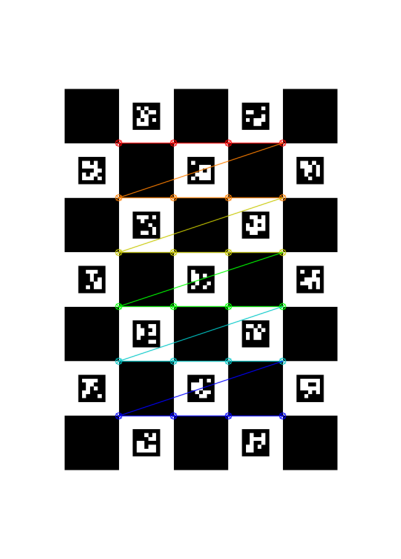

In [ ]:
ls_images = glob.glob('../test_images/charuco_board_pattern.png')
img = cv2.imread(ls_images[0])
# reduce the size of the image since the original is large
img = cv2.resize(img, (0,0), fx=0.25, fy=0.25)
patternSize = (4,6)  # number of inner corners per a chessboard row and column
# patternSize = (6,4)  # number of inner corners per a chessboard row and column

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find chessboard corners
ret, corners = cv2.findChessboardCorners(image=gray, patternSize=patternSize)
# ret is used to denote boolean return value
print( 'Corners found: ', ret )
print( 'Corners shape: ', corners.shape)
print( 'Corners sample: \n', corners[:2] )

# Draw image and display corners
img_corners = cv2.drawChessboardCorners(image=img, patternSize=patternSize, corners=corners, patternWasFound=ret)
plt.figure(figsize=(10,7))
plt.imshow(cv2.cvtColor(img_corners, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# cv2.imshow('Corners', img_corners)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


Note that if you change the pattern size (nx, ny) to (ny, nx) the function still finds the corners but in a different order.

### Refine corner locations to subpixel accuracy

corner_subpix has as inputs:
- image: Input image (grayscale)
- corners: Initial coordinates of the input corners
- winSize: Half of the side length of the search window
- zeroZone: Half of the size of the dead region in the middle of the search zone
- criteria: Termination criteria for the iterative algorithm


In [ ]:
winSize = (11,11)
zeroZone = (-1,-1) # no dead region
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001) # max 30 iterations or move by at least 0.001

corners_subpix = cv2.cornerSubPix(image=gray, corners=corners, winSize=winSize, zeroZone=zeroZone, criteria=criteria)

# Print only the differences between original and refined corners
diff_norm = []
print("Corner Refinement Differences (in pixels):")
for i in range(corners.shape[0]):
    original = corners[i,0]
    refined = corners_subpix[i,0]
    diff = np.linalg.norm(refined - original)
    diff_norm.append(diff)
print(f"Max difference between original and refined corners: {np.max(diff_norm):.4f} pixels")
    

Corner Refinement Differences (in pixels):
Max difference between original and refined corners: 0.0000 pixels


### Camera calibration: Comparison between known pattern and detected corners

The function `cv2.calibrateCamera()` takes as input the known 3D points of the chessboard corners in the world coordinate system and the corresponding 2D points detected in the image. It returns the camera matrix, distortion coefficients, rotation vectors, and translation vectors.

In [ ]:
# Grid of 2D points in real world space
# -------------> x
# |
# |
# v 
# y
# 
# [[0,0], [1,0], ..., [n,0]
#  [0,1], [1,1], ..., [n,1]
#  [0,2], [1,2], ..., [n,2]
#   ... ,  ... , ...,  ...
#  [0,m], [1,m], ..., [n,m]]
# Obtain a grid of 2D points

points_2D = np.mgrid[0:patternSize[0], 0:patternSize[1]]
print("2D Points Grid shape (before reshape): ", points_2D.shape)
print(points_2D)



2D Points Grid shape (before reshape):  (2, 4, 6)
[[[0 0 0 0 0 0]
  [1 1 1 1 1 1]
  [2 2 2 2 2 2]
  [3 3 3 3 3 3]]

 [[0 1 2 3 4 5]
  [0 1 2 3 4 5]
  [0 1 2 3 4 5]
  [0 1 2 3 4 5]]]


First array changes with rows (y coordinate), second array changes with columns (x coordinate). To obtain the correct order we have to transpose the array before reshaping it.

In [ ]:
# Reshape to a list of points with columns as (x, y)
p_2D = points_2D.transpose(2, 1, 0).reshape(-1, 2)
print("2D Points Grid shape (after reshape): ", p_2D.shape)
print("2D Points Grid sample:")
print(p_2D[:7])
print("List of points in an array in C order")

2D Points Grid shape (after reshape):  (24, 2)
2D Points Grid sample:
[[0 0]
 [1 0]
 [2 0]
 [3 0]
 [0 1]
 [1 1]
 [2 1]]
List of points in an array in C order


In [ ]:

# 3D points assuming z=0 for all points (planar chessboard)
points_3D = np.hstack((p_2D, np.zeros((p_2D.shape[0], 1))))
print("3D Points Grid sample:")
print("-"*12)
print("[[x  y  z]]")
print("-"*12)
print(points_3D[:7])
print("List of points in an array in C order with z=0")

3D Points Grid sample:
------------
[[x  y  z]]
------------
[[0. 0. 0.]
 [1. 0. 0.]
 [2. 0. 0.]
 [3. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [2. 1. 0.]]
List of points in an array in C order with z=0


The inputs for the calibration function are:
- objectPoints: A list of arrays containing the 3D coordinates of the chessboard corners in the world coordinate system. Each array corresponds to one image and has a shape of (number_of_corners, 3).
- imagePoints: A list of arrays containing the 2D coordinates of the detected chessboard
corners in the image. Each array corresponds to one image and has a shape of (number_of_corners, 2).
- imageSize: The size of the image used for calibration (Width, Height).

** NOTE: **  
The objectPoints have to be of type float32 for camera calibration to work properly. 

```python
ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(objectPoints, 
                                                                    imagePoints, 
                                                                    imageSize, 
                                                                    cameraMatrix=None, 
                                                                    distCoeffs=None)
```


In [ ]:
# imageSize: The size of the image used for calibration (Width, Height).

[ret, camera_matrix, 
 dist_coeffs, rvecs, 
 tvecs] = cv2.calibrateCamera(objectPoints=[points_3D.astype(np.float32)], 
                              imagePoints=[corners_subpix], 
                              imageSize=gray.shape[::-1], 
                              cameraMatrix=None, 
                              distCoeffs=None)

In [ ]:
#| export
def object_points_cheesboard_grid(pattern_size: tuple[int, int]) -> np.ndarray:
    """
    Prepare object points based on the known flat chessboard pattern size, only the inner corners.
    Order of points is in C order (row-major).
    [ [0 0] -> [0 1] -> ... -> [0 n] -> [1 0] -> [1 1] -> ... -> [m n] ]
    Args:
        pattern_size (tuple[int, int]): Number of inner corners per chessboard row and column (nx, ny).
    Returns:
        np.ndarray: Array of 3D points in the world coordinate system.
    """
    # ---- Prepare object points based on the known flat chessboard pattern ----
    # Obtain a grid of 2D points
    points_2D = np.mgrid[0:pattern_size[0], 0:pattern_size[1]]
    # Reshape to a list of points with columns as (x, y)
    points_2D = points_2D.transpose(2, 1, 0).reshape(-1, 2)
    # 3D points assuming z=0 for all points (planar chessboard) [x, y, z]
    points_3D = np.hstack((points_2D, np.zeros((points_2D.shape[0], 1))))
    # We can cast here to float32 since this is used for camera calibration
    points_3D = points_3D.astype(np.float32)

    return points_3D

In [ ]:
#| export
def saveCoefficients(mtx, dist, reprojection_error, save_path):
    """
    Save camera calibration coefficients to a yaml file.
     - mtx: Camera matrix
     - dist: Distortion coefficients
     - reprojection_error: Reprojection error of the calibration
     - save_path: Directory path where the yaml file will be saved. The file will be named 'camera_calibration.yaml'.
    """

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    file_path = os.path.join(save_path, 'camera_calibration.yaml')
    cv_file = cv2.FileStorage(file_path, cv2.FILE_STORAGE_WRITE)
    cv_file.write("camera_matrix", mtx)
    cv_file.write("dist_coeff", dist)
    cv_file.write("reprojection_error", reprojection_error)
    cv_file.release()
    
def loadCoefficients(load_path):
    """ 
    Load camera calibration coefficients from a yaml file.
     - load_path: Path to the yaml file containing the calibration results.

    Returns: A list containing the camera matrix, distortion coefficients, and reprojection error.
    """

    # Check if the file exists
    if not os.path.exists(load_path):
        raise FileNotFoundError(f"Calibration file not found at {load_path}")

    cv_file = cv2.FileStorage(load_path, cv2.FILE_STORAGE_READ)

    # note we also have to specify the type to retrieve other wise we only get a
    # FileNode object back instead of a matrix
    camera_matrix = cv_file.getNode("camera_matrix").mat()
    dist_matrix = cv_file.getNode("dist_coeff").mat()
    reprojection_error = cv_file.getNode("reprojection_error").real()
    cv_file.release()
    return [camera_matrix, dist_matrix, reprojection_error]

In [ ]:
#| export
def calibrate_camera_from_chessboard_images(image_files: list[str], pattern_size: tuple[int, int], f_save: bool=True):
    """
    Calibrate camera using multiple images of a chessboard pattern.
    
    Parameters:
    - image_files: List of file paths to calibration images.
    - pattern_size: Tuple indicating the number of inner corners per chessboard row and column (nx, ny).
    
    Returns:
    - camera_matrix: The camera matrix.
    - dist_coeffs: The distortion coefficients.
    - reprojection_error: The reprojection error of the calibration.
    """

    # Prepare object points based on the known flat chessboard pattern (cast to float32)
    objp = object_points_cheesboard_grid(pattern_size).astype(np.float32)

    # List of 3D points for each image
    objpoints = []  # 3d point in real world space
    imgpoints = []  # 2d points in image plane.
    # ---------------------------------------------------------------------
    # Criteria for cornerSubPix
    winSize = (11,11)
    zeroZone = (-1,-1) # no dead region
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001) # max 30 iterations or move by at least 0.001


    for fname in image_files:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)

        if ret:
            corners_subpix = cv2.cornerSubPix(gray, corners, winSize, zeroZone, criteria)
            objpoints.append(objp)
            imgpoints.append(corners_subpix)

    _, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    # Calculate reprojection error
    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], camera_matrix, dist_coeffs)
        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
        mean_error += error
    reprojection_error = mean_error / len(objpoints)
    
    print(f"\nTotal reprojection error: {reprojection_error}")
    
    # Save the calibration results
    if f_save:
        save_path = os.path.dirname(image_files[0])
        # Save as a yaml file
        saveCoefficients(camera_matrix, dist_coeffs, reprojection_error, os.path.join(save_path, 'camera_calibration.yaml'))
        print(f"Calibration results saved to {os.path.join(save_path, 'camera_calibration.yaml')}")

    
    return camera_matrix, dist_coeffs, reprojection_error

In [ ]:
image_files = glob.glob('calibration_images/*.png')
pattern_size = (4,6)  

K,D,reproj_eror = calibrate_camera_from_chessboard_images(image_files, pattern_size=(4,6), f_save=False)
print("Camera Matrix:\n", K)
print("Distortion Coefficients:\n", D)



Total reprojection error: 0.13956639879426838
Camera Matrix:
 [[1.90130927e+03 0.00000000e+00 1.32386318e+03]
 [0.00000000e+00 1.98173011e+03 6.81052826e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coefficients:
 [[ 0.18888078 -0.51369385 -0.02181098  0.00801328  0.42930243]]


Test load and save functions for camera calibration results

In [ ]:
K2,D2,reproj_eror2 = loadCoefficients('calibration_images/camera_calibration.yaml')
print("Loaded Camera Matrix:\n", K2)
print("Loaded Distortion Coefficients:\n", D2)
print("Loaded Reprojection Error:\n", reproj_eror2)

Loaded Camera Matrix:
 [[1.90130927e+03 0.00000000e+00 1.32386318e+03]
 [0.00000000e+00 1.98173011e+03 6.81052826e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Loaded Distortion Coefficients:
 [[ 0.18888078 -0.51369385 -0.02181098  0.00801328  0.42930243]]
Loaded Reprojection Error:
 0.13956639879426838
